In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy.io as sio
import librosa

import time

import skimage
import skimage.io
from skimage.transform import rescale

from scipy.io import wavfile
import os
import subprocess

import sys
sys.path.append("../../src")
from spectrogramtools import *
from stego import *
from swpowerstego import *
from imtools import *
from tsp import *
from curvature import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0


(144.13245614035088,
 364.69210526315794,
 -13.749456089330337,
 511.51868158248516)

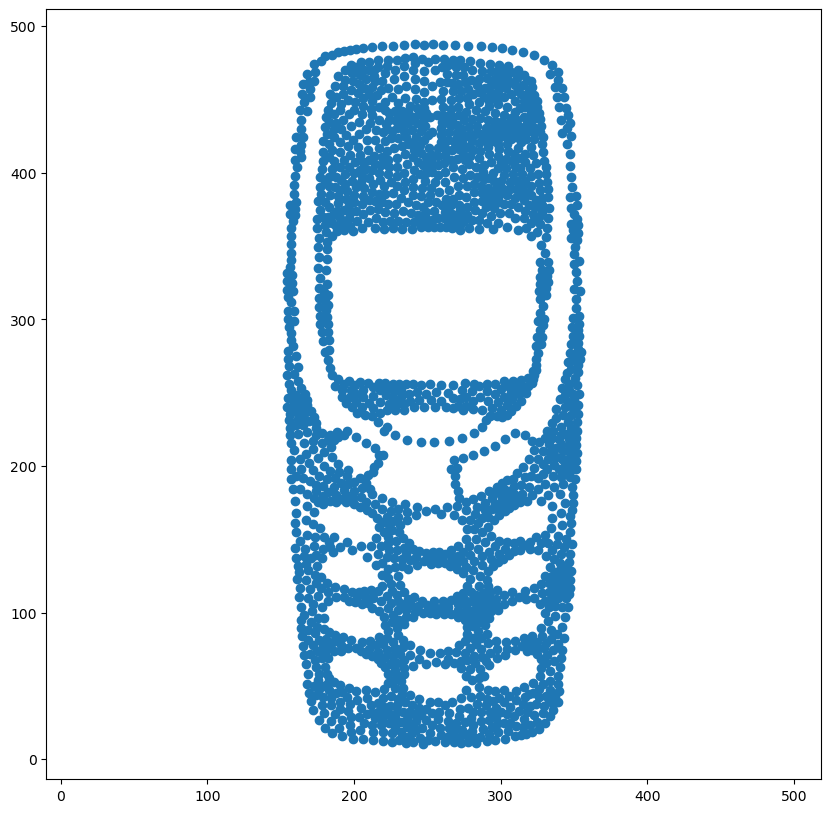

In [32]:
# Image parameters
thresh = 0.5
p = 1
canny_sigma = 0
density_fac= 1
edge_weight = 0
target_points = 2000

np.random.seed(0)
# 31, 67
I = skimage.io.imread("512px-Cell_Phone_-_The_Noun_Project.svg.png")

X = voronoi_stipple(I, thresh, target_points=target_points, p=p, canny_sigma=canny_sigma, edge_weight=edge_weight, n_iters=10, do_plot=False)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1])
plt.axis("equal")

Text(0.5, 1.0, 'After resampling/smoothing')

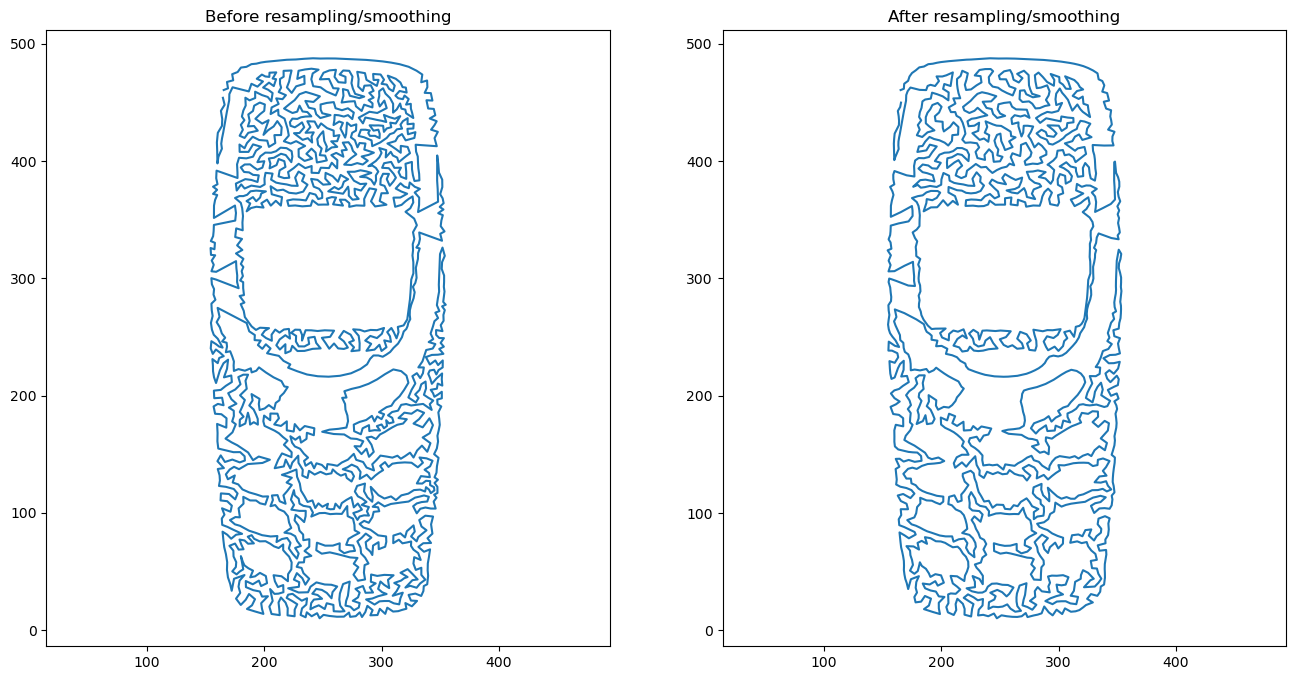

In [33]:
#X = density_filter(X, fac=density_fac, k=2)
X = get_tsp_tour(X)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(X[:, 0], X[:, 1])
plt.axis("equal")
plt.title("Before resampling/smoothing")

s = get_arclen(get_curv_vectors(X, 0, 1, loop=True)[1])
X = arclen_resample(X, s, X.shape[0])
#sigma = 0.1
#X = get_curv_vectors(X, 0, sigma, loop=True)[0]
plt.subplot(122)
plt.plot(X[:, 0], X[: ,1])
plt.axis("equal")
plt.title("After resampling/smoothing")

## Load in audio and compute best target

[43, 86]
viterbi_K =  3
Computing target coordinate 1 of 2...

Elapsed time: 3.111
Computing target coordinate 2 of 2...

Elapsed time: 1.250


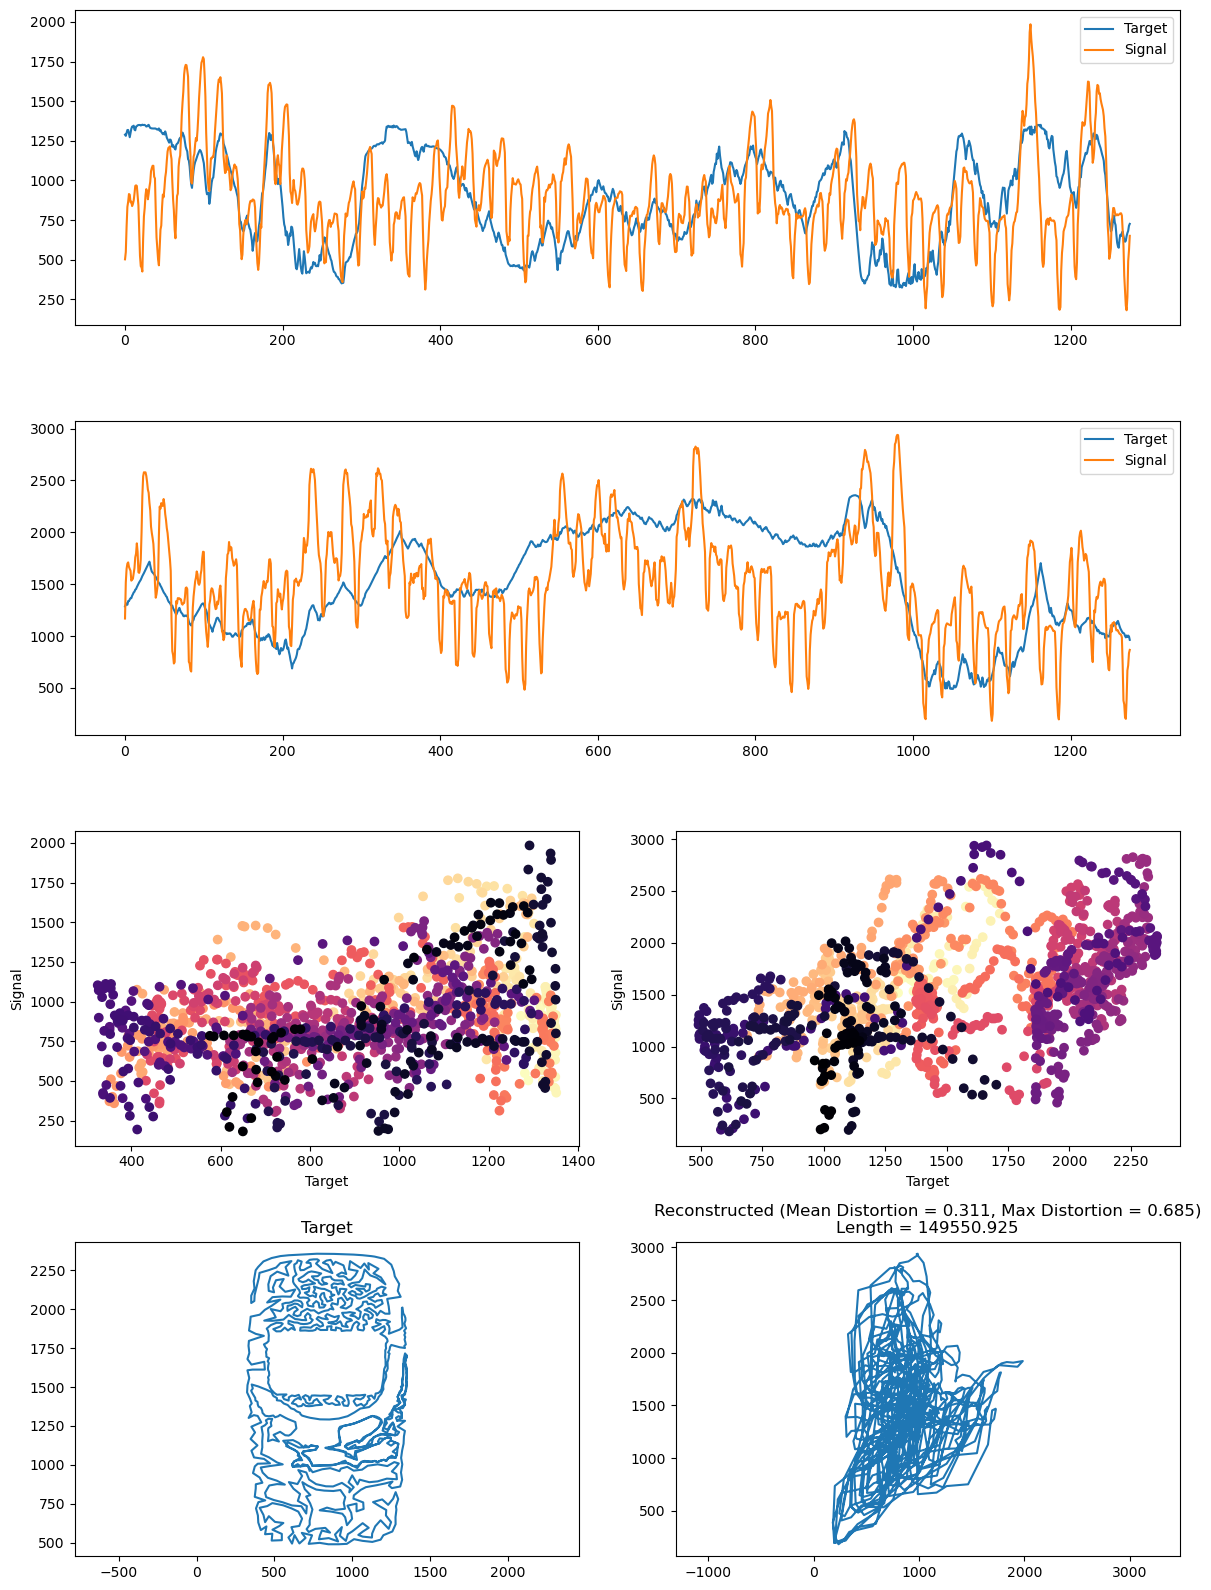

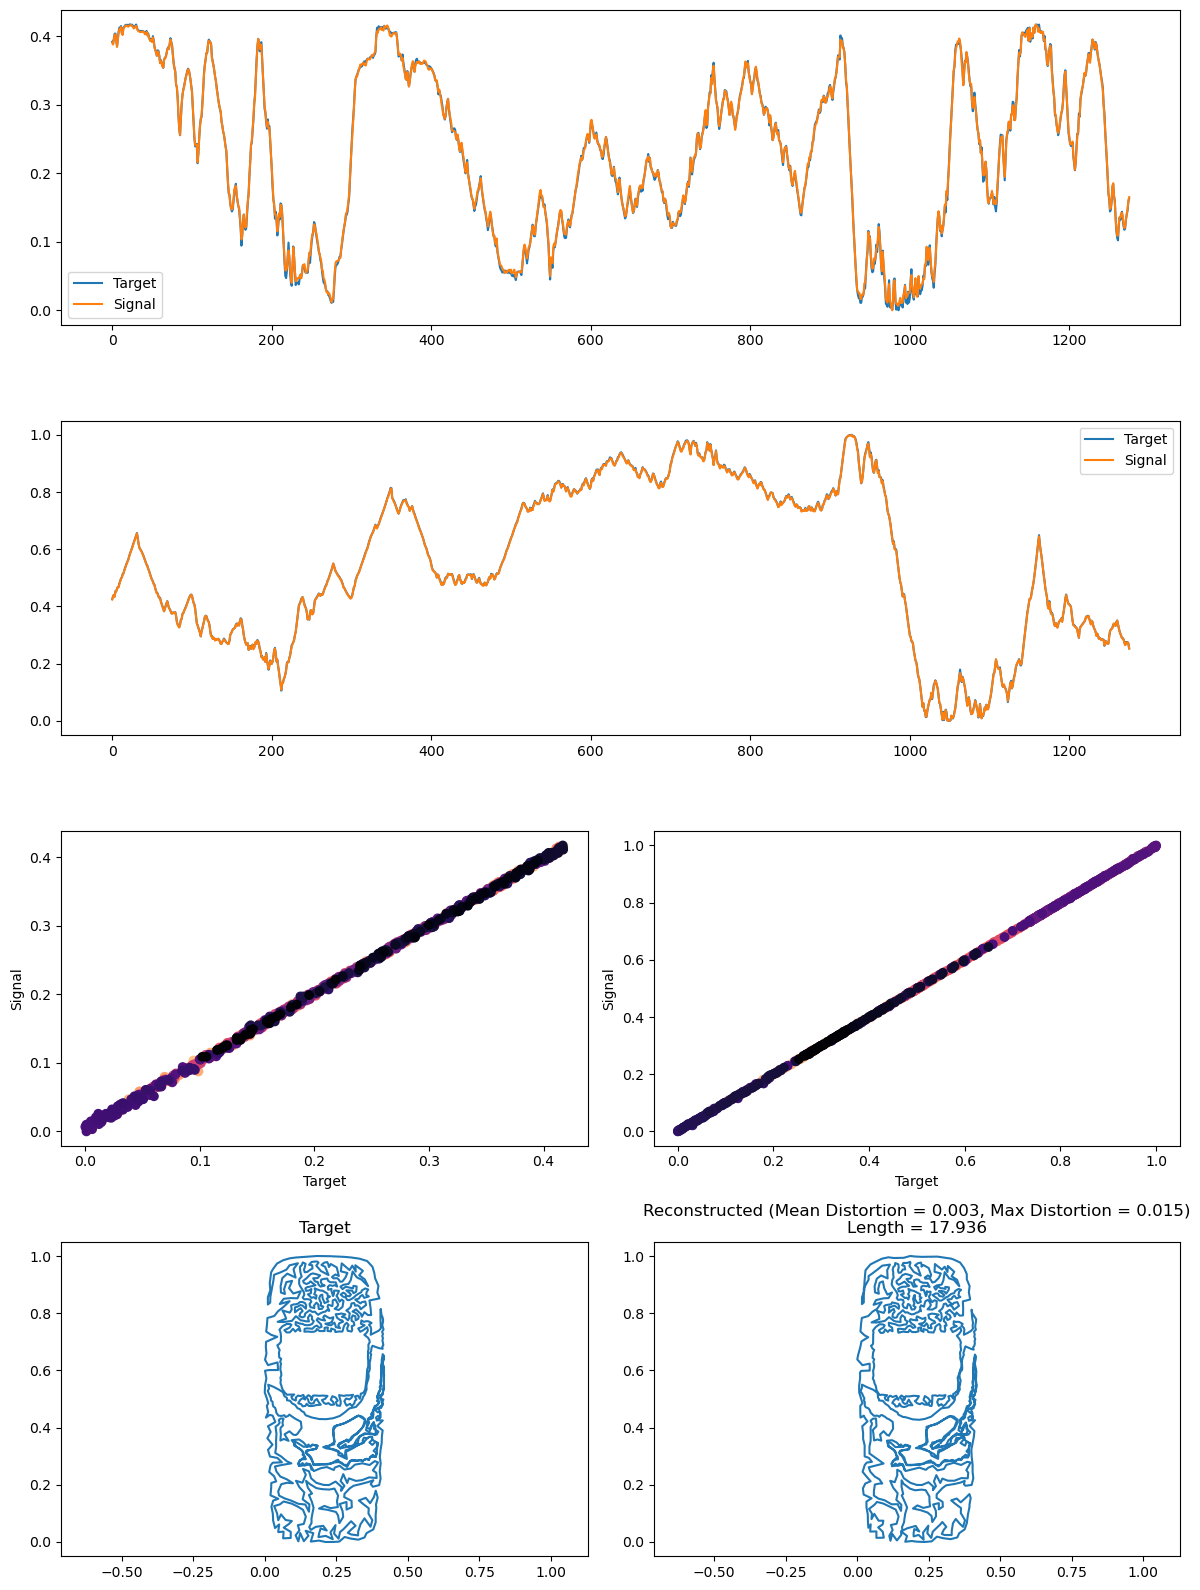

In [34]:
# Audio parameters
x, sr = librosa.load("../../data/tunes/gaga.mp3", sr=44100)
win_length = 1024
mag_idxs = [1, 2]
phase_idxs = mag_idxs
print([int(fi*sr/win_length) for fi in mag_idxs])

# Sliding window parameters
win = 16
fit_lam = 0.1
q = -1

sp = STFTPowerDisjoint(x, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, do_viterbi=True)
sp.plot(normalize=False)

sp.solve()
sp.plot(normalize=True)

In [35]:
y = sp.reconstruct_signal()
ipd.Audio(y, rate=sr)

<Figure size 600x600 with 0 Axes>

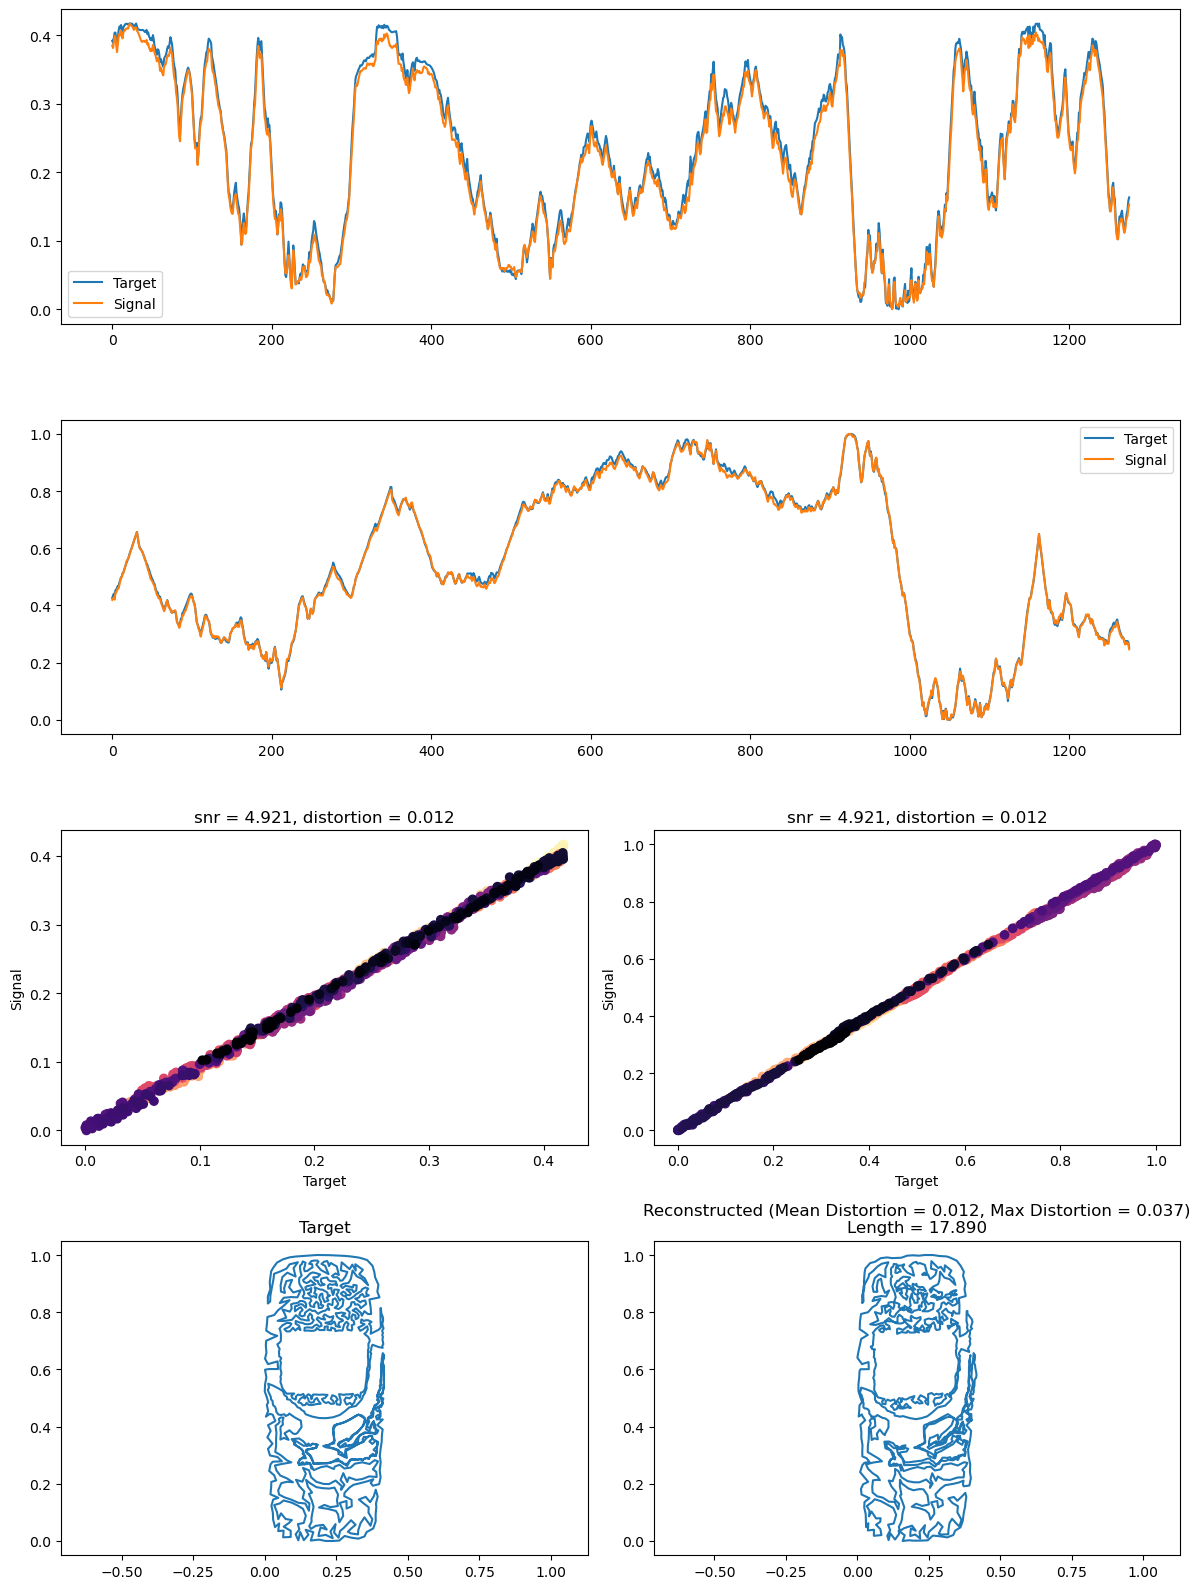

In [36]:
prefix = "gaga-telephone-2d"
filename = "{}.mp3".format(prefix)
wavfile.write("out.wav", sr, y)
if os.path.exists(filename):
    os.remove(filename)
subprocess.call("ffmpeg -i out.wav".split() + [filename], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
os.remove("out.wav")

z, sr = librosa.load(filename, sr=sr)
z_sp = STFTPowerDisjoint(z, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, do_viterbi=False)
z_sp.MagSolver.targets = sp.MagSolver.targets
snr = get_snr(x, z)
distortion = z_sp.get_distortion()[0]
ratio = snr/distortion

title = "snr = {:.3f}, distortion = {:.3f}".format(snr, distortion,)

plt.figure(figsize=(6, 6))
z_sp.plot(True, title)
plt.tight_layout()
plt.savefig("{}.png".format(prefix), facecolor='white')
